In [3]:
import sys
#sys.path
sys.path.append('../')

In [63]:
%load_ext autoreload
%autoreload 2
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data
import exponential_modeling
import fit_and_predict
import copy

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## get prediction for next day

There are currently two models:   
  1. method="exponential" fits an exponential curve to the number of deaths  
  2. method="cases_exponential_rate_constant" fits an exponential curve to the number of cases, and use the death rate of the previous day to estimate deaths  

In [50]:
df = load_data.load_county_level(dir_mod = '../')
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = load_data.outcome_cases # most recent day
outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [34]:
df = exponential_modeling.estimate_deaths(df)

In [30]:
df['predicted_deaths_exponential']

906     438
1423    126
553      47
923      23
124      22
       ... 
540       0
538       0
537       0
534       0
1500      0
Name: predicted_deaths_exponential, Length: 1501, dtype: int64

## Validation (for counties with more than 5 deaths)

In [10]:
df2 = exponential_modeling.create_leave_one_day_out_valid(df)
method = 'cases_exponential_rate_constant'
df2 = exponential_modeling.estimate_deaths(df2, method=method)

In [11]:
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
preds = df2[f'predicted_deaths_{method}']

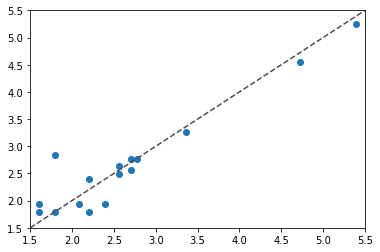

In [12]:
plt.scatter(np.log(preds[outcome > 5]), np.log(outcome[outcome > 5]))
plt.xlim([1.5, 5.5])
plt.ylim([1.5, 5.5])
plt.plot([1.5, 5.5], [1.5, 5.5], ls="--", c=".3")

In [53]:
df = exponential_modeling.estimate_deaths(df, target_day=np.array(range(1, 8)))

## Different time horizon

In [60]:
df['deaths'].values[70]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

In [87]:
h = 3
previous_deaths = [d[:-h] for d in copy.deepcopy(df['deaths'])]
previous_cases = [c[:-h] for c in copy.deepcopy(df['cases'])]
train_df = copy.deepcopy(df)
train_df['deaths'] = previous_deaths
train_df['cases'] = previous_cases
test_df = copy.deepcopy(df)
df_preds = fit_and_predict.fit_and_predict(train_df, test_df, method='exponential', target_day=[h])

In [88]:
preds = [df_preds['predicted_deaths_exponential'].values[i][0] for i in range(len(df))]

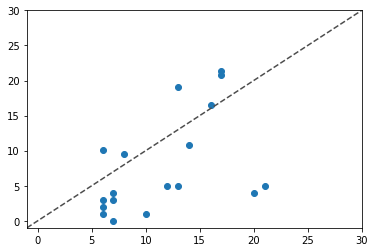

In [89]:
plt.scatter((outcome[outcome > 5]), np.array(preds)[outcome > 5])
axis_lim = [-1, 30]
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.plot(axis_lim, axis_lim, ls="--", c=".3")